In [1]:
import torch
from torch import nn, optim
import mltools

In [2]:
class TransformerCSCModel(nn.Module):
    '''Transformer 分类模型'''

    def __init__(self, *args, vocab_size, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.vocab_size = vocab_size  # 定义词汇表大小
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=256, padding_idx=1)  # 定义嵌入层
        encode_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True)
        self.hidden_layer = nn.TransformerEncoder(encode_layer, num_layers=6)  # 定义隐藏层
        self.output_layer = nn.Linear(256, 2)  # 定义输出层

    def forward(self, x):
        '''前向传播'''
        x = self.embedding(x)  # 将输入嵌入, x形状为(批量大小, 时间步数, 嵌入大小)
        x = self.hidden_layer(x)  # x形状为(批量大小, 时间步数, 隐藏大小)
        x = self.output_layer(x[:, 0, :])  # 它的输出形状是(批量大小, 输出大小)
        return x

In [3]:
class TransformerCSC(mltools.MachineLearning):
    '''Transformer 文本分类学习'''

    @mltools.MachineLearning.trainer
    def train(self, num_epochs):
        '''迭代训练'''
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = x.to(self.device)  # 转换x
                    y = y.to(self.device)  # 转换y
                    y_val = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * y.numel(), val_acc, y.numel())
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data)  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    @mltools.MachineLearning.tester
    def test(self):
        '''测试模型'''
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    @mltools.MachineLearning.predictor
    def predict(self):
        '''预测模型'''
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x = x[:10].to(self.device)
        y = y[:10].to(self.device)
        y_pred = self.model(x)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        for content, pred, real in zip(x, y_pred, y):
            print(f'预测值 {pred}, 真实值 {real}, 数据 {''.join(self.vocab[content.tolist()]).replace('<pad>', ' ')}')

In [4]:
train_iter, val_iter, test_iter, vocab = mltools.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')
model = TransformerCSCModel(vocab_size=len(vocab))  # 定义训练模型
loss = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.SGD(model.parameters(), lr=1)  # 设置优化器
legend = ['train loss', 'val loss', 'val acc']  # 设置图例
device = torch.device('cuda')  # 设置设备
ml = TransformerCSC(train_iter, val_iter, test_iter, vocab=vocab, model=model, loss=loss, optimizer=optimizer, legend=legend, device=device)

2025-05-24 16:23:38,859 - INFO: train loss 1.799, val loss 0.606, val acc 0.713, 45.0 sec/epoch on cuda


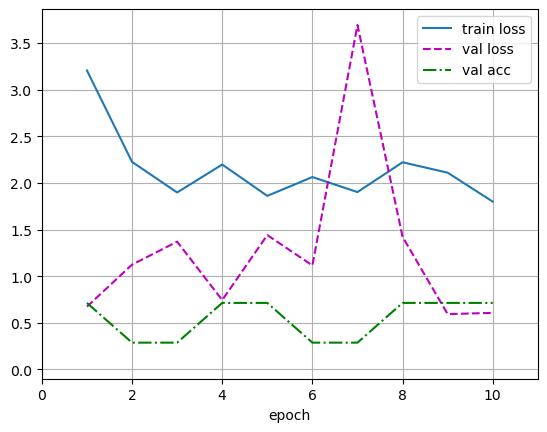

In [5]:
ml.train(num_epochs=10)  # 训练

In [6]:
ml.test()  # 测试

2025-05-24 16:23:41,742 - INFO: test acc 0.694


In [7]:
ml.predict()  # 预测

预测值 1, 真实值 0, 数据 非常糟糕的服务态度,隔音非常差即使是在高层夜晚有火车声第二天搬到远洲国际                                                                                                                                                                    
预测值 1, 真实值 0, 数据 客观地说，这个酒店不怎么样。列出来大家参考：一、晚上八点半到的，没看到门童；二、没有吹风机，三、网线收在电视柜后面，打电话到客房中心才知道还是有网线的；四、第二天想迟个十来分钟退房，前台说没办法，要加收钱，住了这么多酒店头回见着这么呆板的；五、结账时要个信封，没有。六、结账时水单没给我，打电话过去要，说要一点半后再打过去帮我查。这种酒店还能挂星啊？                         
预测值 1, 真实值 1, 数据 服务和早餐都超好对小孩也特别照顾早餐时特别关心房间环境也不错值得推荐                                                                                                                                                                      
预测值 1, 真实值 1, 数据 环境还是挺不错的，工作人员也比较热情，晚上保安<unk><unk>发现窗户没关还电话提醒我们，赞一个！早餐略显一般！酒店门口就是峨眉特色小吃！离旅游车站非常近，线路方便！房间设施虽达不到四星的标准，但在景区也还不错了。可以推荐！                                                                                              
预测值 1, 真实值 0, 数据 天宇也就占了个位置还可以到光，内部设施和消耗品配备，实在是不怎么样，而且，很贵                                                                